In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [8]:
def add_presence_cols(df, cols):
    for col in cols:
        df[col+'_present'] = (df[col] != '?').astype(int)
        
    print("Added presence indicator for columns", cols)

def parse_interval_val(intv):
    if intv == '?':
        return intv
    
    return np.mean(list(map(int, intv[1:-1].split('-'))))

def fix_interval_col(df, colname):
    df[colname] = df[colname].apply(parse_interval_val)
    print("Converted string intervals to numerical values in column", colname)
    return df

def fill_with_means(df, colname):
    non_null = df[colname] != '?'
    mean = np.mean(df[colname][non_null].astype(np.float))
    
    cnt_replaced = np.sum(df[colname] == '?')
    
    df[colname] = df[colname].replace('?', mean)
    print(f"Filled {cnt_replaced} missing values in column {colname} with mean = {mean}")
    
def group_by_patients(df):
    grouped = df.groupby('patient_nbr', axis=0)
    groups = list(grouped.groups.keys())

    for group in groups:
        yield grouped.get_group(group).sort_values('encounter_id')

def remove_1_visit_notinplace(df):
    val_counts = df['patient_nbr'].value_counts()
    patient, visits = val_counts.index, val_counts.values
    multiple_idx = (visits != 1)

    keep_patients = patient[multiple_idx]
    
    index = df['patient_nbr'].map(lambda x: x in keep_patients)
    print("Removed", len(df)-np.sum(index), " records of patients with 1 visit")
    return df[index]
        
def prepare_for_training(df):
    to_append = []

    for group_df in group_by_patients(remove_1_visit_notinplace(df)):
        
#         if (len(group_df) < 6):
#             continue
        
        new_ds = group_df.iloc[:-1].copy() # I will need all but the last row of features
        ordered_vals = group_df['time_in_hospital'].values
                
#         new_ds['current_stay_length_removeme'] = group_df['time_in_hospital']

        new_ds['next_time_in_hospital'] = ordered_vals[1:] # I will need all but the first label
        
        cnt_visits = np.arange(ordered_vals.shape[0] - 1) + 1
        new_ds['which_visit_is_this'] = cnt_visits
        
        cumsum = np.concatenate(([0], np.cumsum(ordered_vals[:-2])))
        new_ds['total_stay_without_this'] = cumsum
        new_ds['mean_stay_without_this'] = np.concatenate(([0], cumsum[1:] / cnt_visits[:-1]))
#         return new_ds
        
        to_append.append(new_ds)

    print("Added columns 'next_time_in_hospital', 'which_visit_is_this', 'total_stay_without_this' and 'mean_stay_without_this'; then removed old 'time_in_hospital'")
    return pd.concat(to_append, ignore_index=True).drop('time_in_hospital', axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scale_column(df, colname, scaler):
#     scaler = StandardScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))[:, 0]
    
    print(f"Scaler: {scaler}, for column", colname)

def scale_columns(df, cols, scaler):
    for col in cols:
        scale_column(df, col, scaler)
        
def bin_columns(df, cols):
    print("One-hot encoded columns", cols)
    return pd.get_dummies(df, columns=cols, drop_first=True)

def get_cat_cols(df):
    return df.select_dtypes(include='object').columns.values

def diag_type(seq):
    
    seq = str(seq)
    
    if seq[0] == 'E':
        return 'injury and poisoning'
    if seq[0] == 'V':
        return 'Supplementary Classification of Factors influencing Health Status and Contact with Health Services'
    if seq[0] == 'M':
        return 'Morphology of Neoplasms'
    
    if seq == '?':
        return '?'
    
    num = float(seq)
    
    if num <= 139:
        return 'Infectious and Parasitic Diseases'
    elif num <= 239:
        return 'Neoplasms'
    elif num <= 279:
        return 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders'
    elif num <= 289:
        return 'Diseases of the Blood and Blood-forming Organs'
    elif num <= 319:
        return 'Mental Disorders'
    elif num <= 389:
        return 'Diseases of the Nervous System and Sense Organs'
    elif num <= 459:
        return 'Diseases of the Circulatory System'
    elif num <= 519:
        return 'Diseases of the Respiratory System'
    elif num <= 579:
        return 'Diseases of the Digestive System'
    elif num <= 629:
        return 'Diseases of the Genitourinary System'
    elif num <= 679:
        return 'Complications of Pregnancy, Childbirth, and the Puerperium'
    elif num <= 709:
        return 'Diseases of the Skin and Subcutaneous Tissue'
    elif num <= 739:
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    elif num <= 759:
        return 'Congenital Anomalies'
    elif num <= 779:
        return 'Certain Conditions originating in the Perinatal Period'
    elif num <= 799:
        return 'Symptoms, Signs and Ill-defined Conditions'
    elif num <= 999:
        return 'Injury and Poisoning'
    else:
        return 'DON\'T KNOW'

def clever_compress_diags_inplace(df):
    diags = ['diag_1', 'diag_2', 'diag_3']
    
    for diag in diags:
        df[diag] = np.vectorize(diag_type)(df[diag])
        
def drop_columns(df, columns):
    print("Dropped columns:", columns)
    return df.drop(columns, axis=1, inplace=True)

def get_unique_pairs(df):
    pairs = []
    
    for col in df.columns:
        pairs.append((col, df[col].unique().shape[0]))
    
    # Sort them by occurrence
    ret = np.array(pairs)
    sort_idx = np.argsort(ret[:, 1].astype(int))
    ret = ret[sort_idx]
    
    return ret

def get_singular_cols(df):
    singular_cols = []
    unq_pairs = get_unique_pairs(df)
    
    for col, unq in unq_pairs:
        if int(unq) == 1:
            singular_cols.append(col)
    
    print("Singular columns:", singular_cols)
    return singular_cols

def get_cols_with_empty(df):
    print("\nA log of missing values for columns:")
    questions = (df == '?')
    
    ret = []

    for col in questions.columns:
        counts = questions[col].value_counts()

        if True in counts.keys().values:
            ret.append(col)
            print(col, 'has', counts[True], 'question marks (', int(counts[True] / questions[col].shape[0] * 100), '%)')
    
    print("\n")
    return ret

def scale_cols_without_response(df, scaler):
    all_columns = current_dataset.columns.values
    index = np.argwhere(all_columns=='next_time_in_hospital')
    non_resp = np.delete(all_columns, index)
    
    scale_columns(current_dataset, non_resp, scaler)

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

class DatasetHolder:
    def __init__(self, X_train, y_train, X_dev, y_dev, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_dev = X_dev
        self.y_dev = y_dev
        
        self.X_test = X_test
        self.y_test = y_test
        
        self.fsize = X_train.shape[1]

def split_simple(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    return DatasetHolder(X_train, y_train, X_dev, y_dev, X_test, y_test)

def split_stratified(X, y):
    str_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
    
    idx_train, idx_test = next(str_split.split(X, y))
    X_train, X_test, y_train, y_test = X[idx_train], X[idx_test], y[idx_train], y[idx_test]
    
    idx_train, idx_dev = next(str_split.split(X_train, y_train))
    X_train, X_dev, y_train, y_dev = X[idx_train], X[idx_dev], y[idx_train], y[idx_dev]
    
    return DatasetHolder(X_train, y_train, X_dev, y_dev, X_test, y_test)

def load_csv(path):
    print(f"Loading dataset from {path}...")
    return pd.read_csv(path)

def load_dataset(df):
    X_full, y_full = df.drop('next_time_in_hospital', axis=1).values, df['next_time_in_hospital'].values
    print(f"Shape of dataset: {X_full.shape}")
    ret = split_stratified(X_full, y_full)
    print(f"Number of features: {ret.fsize}")
    return ret

def load_dataset_from_csv(path):
    return load_dataset(load_csv(path))

In [5]:
full = load_csv('diabetes/diabetic_data_original.csv')

Loading dataset from diabetes/diabetic_data_original.csv...


In [6]:
full_categorical = full.copy()
current_dataset = full_categorical

# Get a next_stay_in_hospital column
current_dataset = prepare_for_training(current_dataset)

# Drop columns of no importance to prediction
drop_columns(current_dataset, ['encounter_id', 'patient_nbr'])

# Drop columns with only 1 value
drop_columns(current_dataset, get_singular_cols(current_dataset))

# Presence columns
add_presence_cols(current_dataset, ['weight', 'payer_code'])

# Fix intervals
fix_interval_col(current_dataset, 'weight')
fix_interval_col(current_dataset, 'age')

# Fill non-present values with the mean
fill_with_means(current_dataset, 'weight')

# print cols with empty for debugging
get_cols_with_empty(current_dataset)

current_dataset = bin_columns(current_dataset, ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
current_dataset = bin_columns(current_dataset, get_cat_cols(current_dataset))

scale_cols_without_response(current_dataset, StandardScaler())

full_categorical = current_dataset
full_categorical

full_cat_ds = load_dataset(full_categorical)

Removed 54745  records of patients with 1 visit


KeyboardInterrupt: 

In [9]:
diags_unscaled = full.copy()
current_dataset = diags_unscaled

# Get a next_stay_in_hospital column
current_dataset = prepare_for_training(current_dataset)

# Drop columns of no importance to prediction
drop_columns(current_dataset, ['encounter_id', 'patient_nbr'])

# Drop columns with only 1 value
drop_columns(current_dataset, get_singular_cols(current_dataset))

# Presence columns
add_presence_cols(current_dataset, ['weight'])

# Fix intervals
fix_interval_col(current_dataset, 'weight')
fix_interval_col(current_dataset, 'age')

# Fill non-present values with the mean
fill_with_means(current_dataset, 'weight')

# Handle categorical data
clever_compress_diags_inplace(current_dataset)

# print cols with empty for debugging
get_cols_with_empty(current_dataset)

current_dataset = bin_columns(current_dataset, 
                              ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
current_dataset = bin_columns(current_dataset, get_cat_cols(current_dataset))

scale_cols_without_response(current_dataset, StandardScaler())

diags_unscaled = current_dataset
standard_scaled = diags_unscaled
diags_ds = load_dataset(diags_unscaled)

Removed 54745  records of patients with 1 visit
Added columns 'next_time_in_hospital', 'which_visit_is_this', 'total_stay_without_this' and 'mean_stay_without_this'; then removed old 'time_in_hospital'
Dropped columns: ['encounter_id', 'patient_nbr']
Singular columns: ['metformin-pioglitazone', 'metformin-rosiglitazone', 'acetohexamide', 'citoglipton', 'examide']
Dropped columns: ['metformin-pioglitazone', 'metformin-rosiglitazone', 'acetohexamide', 'citoglipton', 'examide']
Added presence indicator for columns ['weight']
Converted string intervals to numerical values in column weight
Converted string intervals to numerical values in column age
Filled 29898 missing values in column weight with mean = 83.73571428571428

A log of missing values for columns:
race has 395 question marks ( 1 %)
payer_code has 10171 question marks ( 33 %)
medical_specialty has 15424 question marks ( 50 %)
diag_1 has 4 question marks ( 0 %)
diag_2 has 68 question marks ( 0 %)
diag_3 has 277 question marks ( 0

/home/simeon/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:252: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


One-hot encoded columns ['race' 'gender' 'payer_code' 'medical_specialty' 'diag_1' 'diag_2'
 'diag_3' 'max_glu_serum' 'A1Cresult' 'metformin' 'repaglinide'
 'nateglinide' 'chlorpropamide' 'glimepiride' 'glipizide' 'glyburide'
 'tolbutamide' 'pioglitazone' 'rosiglitazone' 'acarbose' 'miglitol'
 'troglitazone' 'tolazamide' 'insulin' 'glyburide-metformin'
 'glipizide-metformin' 'glimepiride-pioglitazone' 'change' 'diabetesMed'
 'readmitted']
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column age
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column weight
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column num_lab_procedures
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column num_procedures
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column num_medications
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column number_outpatient
Scaler: Standard

Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column glipizide_Up
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column glyburide_No
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column glyburide_Steady
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column glyburide_Up
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column tolbutamide_Steady
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column pioglitazone_No
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column pioglitazone_Steady
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column pioglitazone_Up
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column rosiglitazone_No
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True), for column rosiglitazone_Steady
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True),

In [ ]:
current_dataset = full.copy()

# Get a next_stay_in_hospital column
current_dataset = prepare_for_training(current_dataset)

# Drop columns of no importance to prediction
drop_columns(current_dataset, ['encounter_id', 'patient_nbr'])

# Drop columns with only 1 value
drop_columns(current_dataset, get_singular_cols(current_dataset))

# Presence columns
add_presence_cols(current_dataset, ['weight'])

# Fix intervals
fix_interval_col(current_dataset, 'weight')
fix_interval_col(current_dataset, 'age')

# Fill non-present values with the mean
fill_with_means(current_dataset, 'weight')

# Handle categorical data
clever_compress_diags_inplace(current_dataset)

# print cols with empty for debugging
get_cols_with_empty(current_dataset)

current_dataset = bin_columns(current_dataset, 
                              ['admission_type_id', 'discharge_disposition_id', 'admission_source_id'])
current_dataset = bin_columns(current_dataset, get_cat_cols(current_dataset))

scale_cols_without_response(current_dataset, MinMaxScaler(feature_range=(1, 14)))

minmax_scaled = current_dataset

minmax_diags_ds = load_dataset(minmax_scaled)
minmax_diags_ds.X_train.flatten()

In [ ]:
full_cat_ds = load_dataset(full_categorical)
diags_ds = load_dataset(diags_unscaled)
minmax_diags_ds = load_dataset(minmax_scaled)

In [12]:
from tensorflow.keras.utils import plot_model
import time

def my_poisson_loss(y_actual, y_predicted):
    lmbd = tf.keras.backend.cast(y_predicted, tf.keras.backend.floatx())
    k = tf.keras.backend.cast(y_actual, tf.keras.backend.floatx())
    return lmbd - k*tf.math.log(lmbd)

def my_mean_squared_loss(y_actual, y_predicted):
    lmbd = tf.keras.backend.cast(y_predicted, tf.keras.backend.floatx())
    y_actual = tf.keras.backend.cast(y_actual, tf.keras.backend.floatx())
    
    return (y_actual - y_predicted)**2

def get_baseline_model(ds, loss=my_poisson_loss, last_activation='linear', internal_layers=10):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(ds.fsize, input_shape=(ds.fsize,), activation='relu'))
    
    for i in range(internal_layers):
        model.add(tf.keras.layers.Dense(ds.fsize, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation=last_activation))
    model.compile(optimizer='adam', loss=loss)
    
    return model

def train_model(ds, model, epochs=10):
    history = model.fit(ds.X_train, ds.y_train, 
                        validation_data=(ds.X_dev, ds.y_dev), 
                        epochs=epochs)
    
    return history

def eval_constant_pred(ds):
    mean = np.mean(ds.y_train)
    guesses = np.zeros(ds.y_dev.shape[0]) + mean
    
    return tf.math.reduce_mean(my_mean_squared_loss(ds.y_dev, guesses)).numpy(), tf.math.reduce_mean(my_poisson_loss(ds.y_dev, guesses)).numpy()

def get_loss_val_sequences(history):
    return np.array(history.history['loss']), np.array(history.history['val_loss'])

In [ ]:
eval_constant_pred(diags_ds)

In [ ]:
standard_hist = train_model(diags_ds, get_baseline_model(diags_ds, loss='mean_squared_error', last_activation='linear'), epochs=30)

In [ ]:
# This is from 0 to 1 minmax
save_01_minmax_hist = minmax_hist
# minmax_hist = train_model(minmax_diags_ds, get_baseline_model(minmax_diags_ds, last_relu=False), epochs=30)

In [ ]:
# This is from 1 to 14 minmax
minmax_hist = train_model(minmax_diags_ds, get_baseline_model(minmax_diags_ds, loss=my_mean_squared_loss, last_activation='linear'), epochs=30)

In [ ]:
standard_loss, standard_val_loss = get_loss_val_sequences(standard_hist)
minmax_loss, minmax_val_loss = get_loss_val_sequences(minmax_hist)

all_things = [standard_loss, standard_val_loss, minmax_loss, minmax_val_loss]

total_min = np.amin(all_things)
total_max = np.amax(all_things)

print(np.isnan(total_min))
print(total_min, total_max)

plt.scatter(standard_loss, standard_val_loss, label='standard scaled features')
plt.scatter(minmax_loss, minmax_val_loss, label='minmax scaled features')
plt.plot([total_max, total_min], [total_max, total_min], 'k-')
plt.xlabel('training mean squared loss')
plt.ylabel('validation mean squared loss')
plt.title('Loss with the same model using different scaling techniques')
plt.legend()
plt.savefig('standard vs minmax loss - standard.png')

In [ ]:
model_softplus = get_baseline_model(diags_ds, loss=my_poisson_loss, last_activation='softplus')
train_model(diags_ds, model_softplus)

In [ ]:
model_relu = get_baseline_model(diags_ds, loss=my_poisson_loss, last_activation='relu')
train_model(diags_ds, model_relu)

In [ ]:
preds = model.predict(diags_ds.X_dev)

poisson_loss = tf.math.reduce_mean(my_poisson_loss(diags_ds.y_dev, preds)).numpy()
mse_loss = tf.math.reduce_mean(my_mean_squared_loss(diags_ds.y_dev, preds)).numpy()

poisson_loss, mse_loss

## TODO

* This thing is overfitting like crazy. Do stuff about it & write it up.
* Could also mention the SGD vs Adam learning rate problem

In [44]:
def get_small_model(ds, depth, each, loss=my_poisson_loss, last_activation='softplus', optimizer='adam', dropout=None):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(each, input_shape=(ds.fsize,), activation='relu'))
    
    for i in range(depth-1):
        if dropout is not None:
            model.add(tf.keras.layers.Dropout(dropout))
        
        model.add(tf.keras.layers.Dense(each, activation='relu'))
    
    model.add(tf.keras.layers.Dense(1, activation=last_activation))
    model.compile(optimizer=optimizer, loss=loss)
    
    return model, f"{depth} hidden layers, {each} each; dropout={dropout}"

def get_decreasing_model(ds, start_layer, loss=my_poisson_loss, last_activation='softplus', optimizer='adam', dropout=None):
    layer_sizes = []
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(start_layer, input_shape=(ds.fsize,), activation='relu'))
    layer_sizes.append(start_layer)
    
    cur = start_layer // 2
    depth = 0
    
    while (cur > 1):
        if dropout is not None:
            model.add(tf.keras.layers.Dropout(dropout))
        
        model.add(tf.keras.layers.Dense(cur, activation='relu'))
        
        layer_sizes.append(cur)
        
        cur //= 2
        depth += 1
    
    model.add(tf.keras.layers.Dense(1, activation=last_activation))
    model.compile(optimizer=optimizer, loss=loss)
    
    print(f"Made a model with {depth} hidden layer")
    
    return model, f"dropout= {dropout}, hidden layer sz: " + str(layer_sizes)



def train_until_overfit(ds, model, max_secs=None, patience=5):
    cnt_overfit = 0
    start_time = time.time()
    total_epochs = 0
    
    total_min_loss = None
    histories = []
    
    while cnt_overfit < patience and (max_secs is None or time.time() - start_time < max_secs):
        cur_hist = model.fit(ds.X_train, ds.y_train, 
                             validation_data=(ds.X_dev, ds.y_dev), 
                             epochs=1)
        total_epochs += 1
        histories.append(cur_hist)
        print(f"Minimum val score so far: {total_min_loss}")

        cur_val_loss = cur_hist.history['val_loss'][0]
        if total_min_loss is not None and total_min_loss < cur_val_loss:
            cnt_overfit += 1
            print(f"Patience used: {cnt_overfit} of {patience}")
        else:
            cnt_overfit = 0
            total_min_loss = cur_val_loss
        
    print(f"Did {total_epochs} total epochs until ran out of patience")
    return histories

In [18]:
smalls = [get_small_model(diags_ds, depth=2, each=10),
          get_small_model(diags_ds, depth=5, each=10),
          get_small_model(diags_ds, depth=8, each=10),
          get_small_model(diags_ds, depth=14, each=10)]

decs = [get_decreasing_model(diags_ds, start_layer=diags_ds.fsize), 
        get_decreasing_model(diags_ds, start_layer=diags_ds.fsize // 2),
        get_decreasing_model(diags_ds, start_layer=100),
        get_decreasing_model(diags_ds, start_layer=50),
        get_decreasing_model(diags_ds, start_layer=30)]

big = get_baseline_model(diags_ds, last_activation='softplus')

Made a model with 6 hidden layer
Made a model with 5 hidden layer
Made a model with 5 hidden layer
Made a model with 4 hidden layer
Made a model with 3 hidden layer


In [19]:
hist_smalls = [(train_until_overfit(diags_ds, small, patience=10), name) for small, name in smalls]

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 60us/sample - loss: -2.0744 - val_loss: -2.4414
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 49us/sample - loss: -2.5660 - val_loss: -2.4769
Minimum val score so far: -2.4414135160524983
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 50us/sample - loss: -2.5969 - val_loss: -2.4882
Minimum val score so far: -2.4768778477818514
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 50us/sample - loss: -2.6131 - val_loss: -2.4923
Minimum val score so far: -2.4882185368498493
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 47us/sample - loss: -2.6216 - val_loss: -2.4971
Minimum val score so far: -2.492252173305543
Train on 19358 samples, validate on 4840 samples
19

19358/19358 [==============================] - 1s 50us/sample - loss: -2.6290 - val_loss: -2.5095
Minimum val score so far: -2.5128143874081696
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 50us/sample - loss: -2.6356 - val_loss: -2.5097
Minimum val score so far: -2.5128143874081696
Patience used: 3 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 49us/sample - loss: -2.6412 - val_loss: -2.5111
Minimum val score so far: -2.5128143874081696
Patience used: 4 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 49us/sample - loss: -2.6465 - val_loss: -2.4922
Minimum val score so far: -2.5128143874081696
Patience used: 5 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 50us/sample - loss: -2.6522 - val_loss: -2.5060
Minimum val score so far: -2.512814387

In [20]:
hist_decs = [(train_until_overfit(diags_ds, dec, patience=10), name) for dec, name in decs]

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 83us/sample - loss: -2.4526 - val_loss: -2.5046
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 68us/sample - loss: -2.6218 - val_loss: -2.5145
Minimum val score so far: -2.5046127212934257
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 66us/sample - loss: -2.6524 - val_loss: -2.5064
Minimum val score so far: -2.5145346720356585
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 65us/sample - loss: -2.6785 - val_loss: -2.4947
Minimum val score so far: -2.5145346720356585
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 65us/sample - loss: -2.7079 - val_loss: -2.4378
Minimum val score so far: -2.5145346720356585
Pati

Minimum val score so far: -2.471683830072072
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 68us/sample - loss: -2.5383 - val_loss: -2.4716
Minimum val score so far: -2.471683830072072
Patience used: 3 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 60us/sample - loss: -2.5383 - val_loss: -2.4715
Minimum val score so far: -2.471683830072072
Patience used: 4 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 58us/sample - loss: -2.5383 - val_loss: -2.4715
Minimum val score so far: -2.471683830072072
Patience used: 5 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 51us/sample - loss: -2.5383 - val_loss: -2.4715
Minimum val score so far: -2.471683830072072
Patience used: 6 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==========

19358/19358 [==============================] - 1s 42us/sample - loss: -2.6924 - val_loss: -2.4791
Minimum val score so far: -2.5066954994989823
Patience used: 4 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 43us/sample - loss: -2.7053 - val_loss: -2.4743
Minimum val score so far: -2.5066954994989823
Patience used: 5 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 45us/sample - loss: -2.7160 - val_loss: -2.4504
Minimum val score so far: -2.5066954994989823
Patience used: 6 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 44us/sample - loss: -2.7301 - val_loss: -2.4363
Minimum val score so far: -2.5066954994989823
Patience used: 7 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 52us/sample - loss: -2.7413 - val_loss: -2.4256
Minimum val score so far: -2.506695499

In [ ]:
hist_big = train_until_overfit(diags_ds, big, patience=10)

In [21]:
def get_loss_list(lhist):
    loss = []
    val_loss = []
    
    for h in lhist:
        cur_loss, cur_val = get_loss_val_sequences(h)
        
        for x in cur_loss:
            loss.append(x)
            
        for x in cur_val:
            val_loss.append(x)
    
    return np.array(loss), np.array(val_loss)

def plot_lhist_line(lhist, title):
    loss, val_loss = get_loss_list(lhist)

    plt.plot(np.arange(loss.shape[0]), loss, label=f'{title} train loss')
    plt.plot(np.arange(val_loss.shape[0]), val_loss, label=f'{title} val loss')
    plt.legend()
    
def plot_lhist_scatter(lhist, title):
    loss, val_loss = get_loss_list(lhist)
    
    plt.plot(loss, val_loss, label=title, alpha=0.9)
    plt.scatter(loss, val_loss, alpha=0.3)
    plt.xlabel('training loss')
    plt.ylabel('validation loss')
    plt.legend()
    
    all_vals = np.array([loss, val_loss])
    return np.amin(all_vals), np.amax(all_vals)

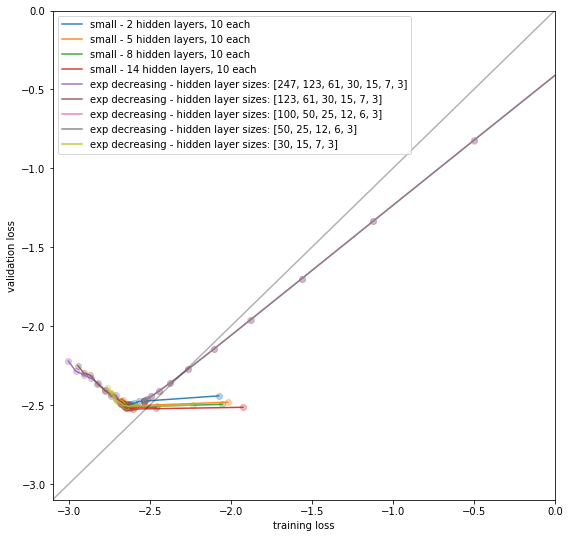

In [68]:
def plot_bunch_hists(hists, bunch_name):
    total_min=999
    total_max=-999

    for i, (hist, name) in zip(range(len(hists)), hists):
        mn, mx = plot_lhist_scatter(hist, f'{bunch_name} - {name}')

        total_min = min(total_min, mn)
        total_max = max(total_max, mx)
    
    total_abs = max(abs(total_min), abs(total_max))
    
#     plt.plot([-total_abs, total_abs], [-total_abs, total_abs], 'k-')
#     plt.show()

plt.figure(figsize=(9, 9))
plot_bunch_hists(hist_smalls, 'small')
plot_bunch_hists(hist_decs, 'exp decreasing')

to_show = (-3.1, 0)
plt.plot(to_show, to_show, 'k-', alpha=0.3)
plt.xlim(to_show)
plt.ylim(to_show)
plt.savefig('bunch of models - new - new -3.1 0.png')

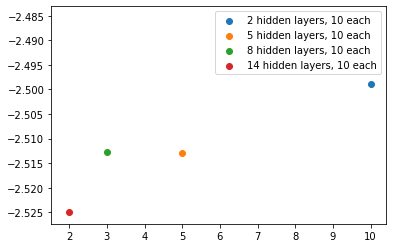

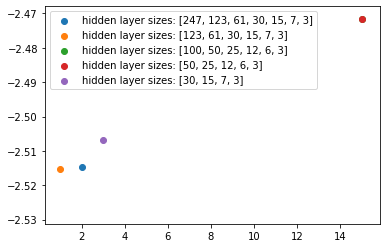

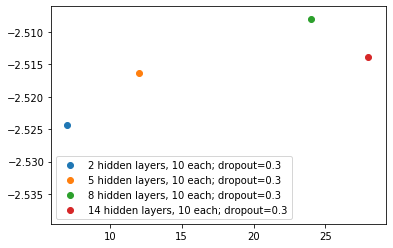

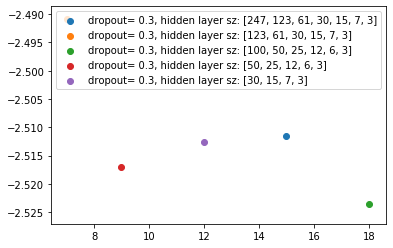

In [93]:
def get_val_loss(hist_holder):
    return hist_holder.history['val_loss']

def steps_to_converge(single_histories):
    val_losses = np.array([get_val_loss(hist_holder) for hist_holder in single_histories])
    min_idx = np.argmin(val_losses)
    
    return min_idx + 1, val_losses[min_idx]

def all_steps(history_list):
    all_steps = []
    all_vals = []
    all_names = []
    
    for single_hist, name in history_list:
        steps, val = steps_to_converge(single_hist)
        
        all_steps.append(steps)
        all_vals.append(val)
        all_names.append(name)
        
    return all_steps, all_vals, all_names

def make_scatter_for(hist):
    steps, vals, names = all_steps(hist)

    for step, val, name in zip(steps, vals, names):
        plt.scatter(step, val, label=name)

    plt.legend()
    
make_scatter_for(hist_smalls)
plt.show()
make_scatter_for(hist_decs)
plt.show()
make_scatter_for(hist_smalls_dropout)
plt.show()
make_scatter_for(hist_decs_dropout)
plt.show()

In [94]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=100, optimizer='adam', dropout=0.3)[0], patience=20)

Made a model with 5 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 95us/sample - loss: -1.6670 - val_loss: -2.3700
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 73us/sample - loss: -2.2947 - val_loss: -2.4201
Minimum val score so far: -2.369982592133451
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -2.4046 - val_loss: -2.4141
Minimum val score so far: -2.420124410597746
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -2.4700 - val_loss: -2.4634
Minimum val score so far: -2.420124410597746
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -2.5159 - val_loss: -2.4382
Minimum val score so far: -2.46342137116046

Minimum val score so far: -2.5030033789390376
Patience used: 19 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 68us/sample - loss: -2.7575 - val_loss: -2.4471
Minimum val score so far: -2.5030033789390376
Patience used: 20 of 20
Did 40 total epochs until ran out of patience


## Trying tiny tiny networks

In [27]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=1, each=3, optimizer='adam')[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 52us/sample - loss: 0.8465 - val_loss: -0.7110
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 44us/sample - loss: -1.5764 - val_loss: -1.6904
Minimum val score so far: -0.710981241730619
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 45us/sample - loss: -2.1642 - val_loss: -2.0780
Minimum val score so far: -1.690394156629389
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 45us/sample - loss: -2.3699 - val_loss: -2.2702
Minimum val score so far: -2.078008301839356
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 45us/sample - loss: -2.5073 - val_loss: -2.4195
Minimum val score so far: -2.2701602547621924
Train on 19358 samples, validate on 4840 samples
19358

In [30]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=1, each=20, optimizer='adam')[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 57us/sample - loss: -1.7642 - val_loss: -2.2094
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 49us/sample - loss: -2.5225 - val_loss: -2.3705
Minimum val score so far: -2.2094474116632763
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 49us/sample - loss: -2.5851 - val_loss: -2.4442
Minimum val score so far: -2.3704804688445793
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 51us/sample - loss: -2.6098 - val_loss: -2.4599
Minimum val score so far: -2.444245769563785
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 51us/sample - loss: -2.6260 - val_loss: -2.4756
Minimum val score so far: -2.459919572073566
Train on 19358 samples, validate on 4840 samples
193

## Dropout

In [32]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=14, each=20, optimizer='adam', dropout=0.5)[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 118us/sample - loss: -1.6935 - val_loss: -2.4618
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 81us/sample - loss: -2.4668 - val_loss: -2.4711
Minimum val score so far: -2.4618152555355355
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 83us/sample - loss: -2.5095 - val_loss: -2.4710
Minimum val score so far: -2.4710956620775963
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 90us/sample - loss: -2.5258 - val_loss: -2.4712
Minimum val score so far: -2.4710956620775963
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 79us/sample - loss: -2.5329 - val_loss: -2.4715
Minimum val score so far: -2.471230895854225
Train on 19358 samples, val

19358/19358 [==============================] - 2s 83us/sample - loss: -2.5772 - val_loss: -2.4613
Minimum val score so far: -2.4896710632261168
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 84us/sample - loss: -2.5745 - val_loss: -2.4756
Minimum val score so far: -2.4896710632261168
Patience used: 2 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 84us/sample - loss: -2.5749 - val_loss: -2.4750
Minimum val score so far: -2.4896710632261168
Patience used: 3 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 92us/sample - loss: -2.5753 - val_loss: -2.4737
Minimum val score so far: -2.4896710632261168
Patience used: 4 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 88us/sample - loss: -2.5765 - val_loss: -2.4827
Minimum val score so far: -2.489671063

19358/19358 [==============================] - 1s 76us/sample - loss: -2.5866 - val_loss: -2.4817
Minimum val score so far: -2.4975738072198284
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 82us/sample - loss: -2.5818 - val_loss: -2.4943
Minimum val score so far: -2.4975738072198284
Patience used: 2 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 83us/sample - loss: -2.5855 - val_loss: -2.4890
Minimum val score so far: -2.4975738072198284
Patience used: 3 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 84us/sample - loss: -2.5894 - val_loss: -2.4876
Minimum val score so far: -2.4975738072198284
Patience used: 4 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 90us/sample - loss: -2.5874 - val_loss: -2.4941
Minimum val score so far: -2.497573807

19358/19358 [==============================] - 2s 80us/sample - loss: -2.5926 - val_loss: -2.5012
Minimum val score so far: -2.5028708205735386
Patience used: 14 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 82us/sample - loss: -2.5916 - val_loss: -2.5073
Minimum val score so far: -2.5028708205735386
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 81us/sample - loss: -2.5885 - val_loss: -2.5024
Minimum val score so far: -2.5073456716931557
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 85us/sample - loss: -2.5932 - val_loss: -2.4921
Minimum val score so far: -2.5073456716931557
Patience used: 2 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 84us/sample - loss: -2.5880 - val_loss: -2.5045
Minimum val score so far: -2.5073456716931557
Patience used:

In [33]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=14, each=20, optimizer='adam', dropout=0.3)[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 119us/sample - loss: -1.8633 - val_loss: -2.4709
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 79us/sample - loss: -2.4732 - val_loss: -2.4715
Minimum val score so far: -2.4708624508755266
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 79us/sample - loss: -2.4963 - val_loss: -2.4716
Minimum val score so far: -2.47145516852702
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 80us/sample - loss: -2.5140 - val_loss: -2.4712
Minimum val score so far: -2.4716348549551217
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 92us/sample - loss: -2.5275 - val_loss: -2.4753
Minimum val score so far: -2.4716348549551217
Train on 19358 samples, vali

In [35]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=14, each=10, optimizer='adam', dropout=0.3)[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 113us/sample - loss: -1.4341 - val_loss: -2.4698
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 79us/sample - loss: -2.4102 - val_loss: -2.4705
Minimum val score so far: -2.4698465158131495
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 80us/sample - loss: -2.4790 - val_loss: -2.4658
Minimum val score so far: -2.4705214224571037
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 82us/sample - loss: -2.5080 - val_loss: -2.4646
Minimum val score so far: -2.4705214224571037
Patience used: 2 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 82us/sample - loss: -2.5181 - val_loss: -2.4709
Minimum val score so far: -2.4705214224571037
Tra

Minimum val score so far: -2.5058973095633768
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 86us/sample - loss: -2.5838 - val_loss: -2.5089
Minimum val score so far: -2.5058973095633768
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 84us/sample - loss: -2.5844 - val_loss: -2.4984
Minimum val score so far: -2.508898224712403
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 87us/sample - loss: -2.5924 - val_loss: -2.5002
Minimum val score so far: -2.508898224712403
Patience used: 2 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 90us/sample - loss: -2.5841 - val_loss: -2.5037
Minimum val score so far: -2.508898224712403
Patience used: 3 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================]

19358/19358 [==============================] - 2s 81us/sample - loss: -2.6177 - val_loss: -2.5059
Minimum val score so far: -2.5129501445234315
Patience used: 8 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 82us/sample - loss: -2.6163 - val_loss: -2.5079
Minimum val score so far: -2.5129501445234315
Patience used: 9 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 86us/sample - loss: -2.6140 - val_loss: -2.5054
Minimum val score so far: -2.5129501445234315
Patience used: 10 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 88us/sample - loss: -2.6154 - val_loss: -2.5115
Minimum val score so far: -2.5129501445234315
Patience used: 11 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 93us/sample - loss: -2.6152 - val_loss: -2.5090
Minimum val score so far: -2.5129501

In [36]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=100, optimizer='adam', dropout=0.3)[0], patience=20)

Made a model with 5 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 93us/sample - loss: -1.3974 - val_loss: -2.3231
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 83us/sample - loss: -2.2881 - val_loss: -2.2741
Minimum val score so far: -2.323113085612778
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 75us/sample - loss: -2.4437 - val_loss: -2.4376
Minimum val score so far: -2.323113085612778
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 77us/sample - loss: -2.5217 - val_loss: -2.4866
Minimum val score so far: -2.4375528382860923
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 78us/sample - loss: -2.5571 - val_loss: -2.5018
Minimum val score so far: -2.4866131010134

In [37]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=100, optimizer='adam', dropout=0.5)[0], patience=20)

Made a model with 5 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 95us/sample - loss: -1.2505 - val_loss: -1.8095
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 80us/sample - loss: -2.1534 - val_loss: -2.3833
Minimum val score so far: -1.8095122877231313
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -2.4294 - val_loss: -2.4569
Minimum val score so far: -2.383279981691975
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 80us/sample - loss: -2.4990 - val_loss: -2.4689
Minimum val score so far: -2.4568517141105715
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 80us/sample - loss: -2.5296 - val_loss: -2.4691
Minimum val score so far: -2.4689010391550616
Train on 19358 sam

19358/19358 [==============================] - 1s 72us/sample - loss: -2.6174 - val_loss: -2.4802
Minimum val score so far: -2.4899545448870697
Patience used: 19 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 71us/sample - loss: -2.6195 - val_loss: -2.4842
Minimum val score so far: -2.4899545448870697
Patience used: 20 of 20
Did 41 total epochs until ran out of patience


In [38]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=50, optimizer='adam', dropout=0.5)[0], patience=20)

Made a model with 4 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 82us/sample - loss: -0.5584 - val_loss: -1.9676
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 64us/sample - loss: -1.9069 - val_loss: -2.1650
Minimum val score so far: -1.9675796607309137
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 66us/sample - loss: -2.3000 - val_loss: -2.3825
Minimum val score so far: -2.165031225819233
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 68us/sample - loss: -2.4455 - val_loss: -2.4489
Minimum val score so far: -2.3824733048431144
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 66us/sample - loss: -2.5071 - val_loss: -2.4557
Minimum val score so far: -2.448893586466135
Train on 19358 samp

19358/19358 [==============================] - 1s 63us/sample - loss: -2.6198 - val_loss: -2.4828
Minimum val score so far: -2.5001359340573144
Patience used: 20 of 20
Did 40 total epochs until ran out of patience


In [39]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=20, optimizer='adam', dropout=0.5)[0], patience=20)

Made a model with 3 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 69us/sample - loss: -1.2110 - val_loss: -2.1863
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 54us/sample - loss: -2.1643 - val_loss: -2.4114
Minimum val score so far: -2.186251396384121
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 53us/sample - loss: -2.4470 - val_loss: -2.4663
Minimum val score so far: -2.4114356218290722
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 55us/sample - loss: -2.5172 - val_loss: -2.4745
Minimum val score so far: -2.4663217493325225
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 59us/sample - loss: -2.5336 - val_loss: -2.4742
Minimum val score so far: -2.4745256408186984
Patience used: 1 o

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 55us/sample - loss: -2.5999 - val_loss: -2.4841
Minimum val score so far: -2.510318370692986
Patience used: 15 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 52us/sample - loss: -2.5964 - val_loss: -2.4714
Minimum val score so far: -2.510318370692986
Patience used: 16 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 57us/sample - loss: -2.6024 - val_loss: -2.4606
Minimum val score so far: -2.510318370692986
Patience used: 17 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 60us/sample - loss: -2.6023 - val_loss: -2.4569
Minimum val score so far: -2.510318370692986
Patience used: 18 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 61us/sample - loss: -2.6010 - val_los

In [40]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=15, optimizer='adam', dropout=0.5)[0], patience=20)

Made a model with 2 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -0.5991 - val_loss: -2.0892
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 53us/sample - loss: -2.1670 - val_loss: -2.3278
Minimum val score so far: -2.089169160590684
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 62us/sample - loss: -2.4293 - val_loss: -2.4689
Minimum val score so far: -2.3278041488868144
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 54us/sample - loss: -2.5160 - val_loss: -2.4746
Minimum val score so far: -2.46893266606922
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 55us/sample - loss: -2.5437 - val_loss: -2.4839
Minimum val score so far: -2.474556732177734
Train on 19358 sample

In [41]:
train_until_overfit(diags_ds, get_decreasing_model(diags_ds, start_layer=100, optimizer='adam', dropout=0.8)[0], patience=20)

Made a model with 5 hidden layer
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 116us/sample - loss: 0.8760 - val_loss: -0.2080
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 73us/sample - loss: -1.0696 - val_loss: -2.0446
Minimum val score so far: -0.20795923472682307
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 75us/sample - loss: -2.0755 - val_loss: -2.4211
Minimum val score so far: -2.04457808132014
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -2.4078 - val_loss: -2.4614
Minimum val score so far: -2.4211384816603227
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 78us/sample - loss: -2.4957 - val_loss: -2.4715
Minimum val score so far: -2.461443910914019
Train on 19358 samp

KeyboardInterrupt: 

In [46]:
smalls_dropout = [get_small_model(diags_ds, depth=2, each=10, dropout=0.3),
          get_small_model(diags_ds, depth=5, each=10, dropout=0.3),
          get_small_model(diags_ds, depth=8, each=10, dropout=0.3),
          get_small_model(diags_ds, depth=14, each=10, dropout=0.3)]

decs_dropout = [get_decreasing_model(diags_ds, start_layer=diags_ds.fsize, dropout=0.3), 
        get_decreasing_model(diags_ds, start_layer=diags_ds.fsize // 2, dropout=0.3),
        get_decreasing_model(diags_ds, start_layer=100, dropout=0.3),
        get_decreasing_model(diags_ds, start_layer=50, dropout=0.3),
        get_decreasing_model(diags_ds, start_layer=30, dropout=0.3)]

Made a model with 6 hidden layer
Made a model with 5 hidden layer
Made a model with 5 hidden layer
Made a model with 4 hidden layer
Made a model with 3 hidden layer


In [47]:
hist_decs_dropout = [(train_until_overfit(diags_ds, dec, patience=10), name) for dec, name in decs]
hist_smalls_dropout = [(train_until_overfit(diags_ds, small, patience=10), name) for small, name in smalls]

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 121us/sample - loss: 1.6930 - val_loss: 0.9559
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 96us/sample - loss: -0.8093 - val_loss: -2.4014
Minimum val score so far: 0.9559131680441296
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 96us/sample - loss: -2.3077 - val_loss: -2.4422
Minimum val score so far: -2.4013886164042577
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 102us/sample - loss: -2.4340 - val_loss: -2.5069
Minimum val score so far: -2.4422485997854184
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 102us/sample - loss: -2.4965 - val_loss: -2.5035
Minimum val score so far: -2.5068928426947474
Patience used: 1 of 10
Train on 19358 samples, val

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 69us/sample - loss: -2.6604 - val_loss: -2.4260
Minimum val score so far: -2.490780199854827
Patience used: 8 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 71us/sample - loss: -2.6675 - val_loss: -2.4405
Minimum val score so far: -2.490780199854827
Patience used: 9 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 69us/sample - loss: -2.6713 - val_loss: -2.3941
Minimum val score so far: -2.490780199854827
Patience used: 10 of 10
Did 17 total epochs until ran out of patience
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 88us/sample - loss: -1.2803 - val_loss: -2.3464
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 66us/sample - loss: -2.2242 - v

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 60us/sample - loss: -2.6007 - val_loss: -2.5169
Minimum val score so far: -2.5113489947043175
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 58us/sample - loss: -2.6135 - val_loss: -2.5077
Minimum val score so far: -2.516949304076266
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 57us/sample - loss: -2.6085 - val_loss: -2.5080
Minimum val score so far: -2.516949304076266
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 60us/sample - loss: -2.6130 - val_loss: -2.5163
Minimum val score so far: -2.516949304076266
Patience used: 3 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 56us/sample - loss: -2.6328 - val_loss: -2.5074
Minimum val sco

19358/19358 [==============================] - 1s 48us/sample - loss: -2.6049 - val_loss: -2.5243
Minimum val score so far: -2.5242668794206353
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 48us/sample - loss: -2.6085 - val_loss: -2.5224
Minimum val score so far: -2.5242852904579856
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 50us/sample - loss: -2.6181 - val_loss: -2.5206
Minimum val score so far: -2.5242852904579856
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 51us/sample - loss: -2.6153 - val_loss: -2.5190
Minimum val score so far: -2.5242852904579856
Patience used: 3 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 51us/sample - loss: -2.6192 - val_loss: -2.5181
Minimum val score so far: -2.5242852904579856
Patience used: 

19358/19358 [==============================] - 1s 63us/sample - loss: -2.5320 - val_loss: -2.4700
Minimum val score so far: -2.4722453117370606
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 63us/sample - loss: -2.5371 - val_loss: -2.4706
Minimum val score so far: -2.4722453117370606
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 62us/sample - loss: -2.5438 - val_loss: -2.4772
Minimum val score so far: -2.4722453117370606
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 64us/sample - loss: -2.5523 - val_loss: -2.4700
Minimum val score so far: -2.4772220426354528
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 64us/sample - loss: -2.5565 - val_loss: -2.4684
Minimum val score so far: -2.4772220426354528
Patience used: 

19358/19358 [==============================] - 2s 78us/sample - loss: -2.5616 - val_loss: -2.4784
Minimum val score so far: -2.478815250554361
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 81us/sample - loss: -2.5652 - val_loss: -2.4892
Minimum val score so far: -2.478815250554361
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 2s 78us/sample - loss: -2.5735 - val_loss: -2.4860
Minimum val score so far: -2.48921172677978
Patience used: 1 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 77us/sample - loss: -2.5766 - val_loss: -2.4883
Minimum val score so far: -2.48921172677978
Patience used: 2 of 10
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 76us/sample - loss: -2.5790 - val_loss: -2.4944
Minimum val score so far: -2.48921172677978
Train on 19358 samples,

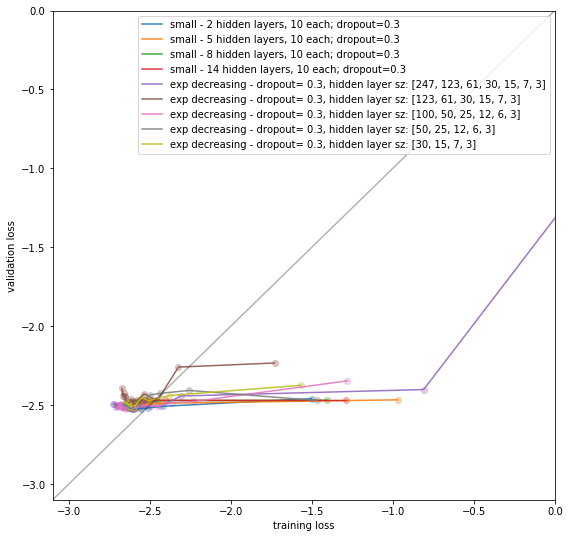

In [51]:
plt.figure(figsize=(9,9))
plot_bunch_hists(hist_smalls_dropout, 'small')
plot_bunch_hists(hist_decs_dropout, 'exp decreasing')

to_show = (-3.1, 0)
plt.plot(to_show, to_show, 'k-', alpha=0.3)
plt.xlim(to_show)
plt.ylim(to_show)
plt.savefig('bunch of models - new - new - dropout.png')

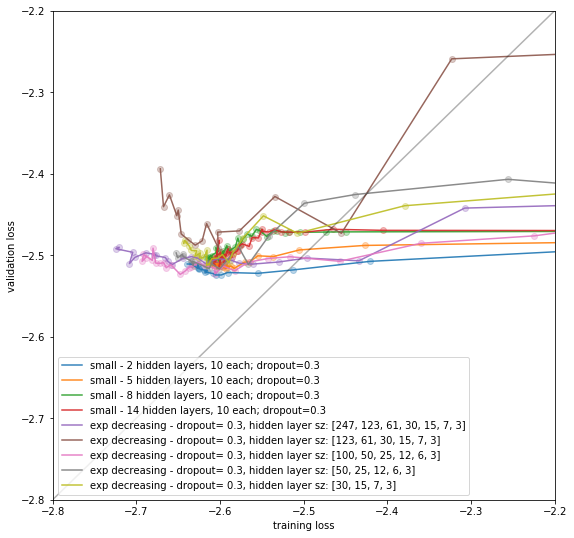

In [63]:
plt.figure(figsize=(9,9))
plot_bunch_hists(hist_smalls_dropout, 'small')
plot_bunch_hists(hist_decs_dropout, 'exp decreasing')

to_show = (-2.8, -2.2)
plt.plot(to_show, to_show, 'k-', alpha=0.3)
plt.xlim(to_show)
plt.ylim(to_show)
plt.savefig('bunch of models - new - new - dropout - closer.png')

In [55]:
train_until_overfit(diags_ds, get_baseline_model(diags_ds, last_activation='softplus'))

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 5s 235us/sample - loss: -2.5044 - val_loss: -2.5225
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 209us/sample - loss: -2.6105 - val_loss: -2.5192
Minimum val score so far: -2.5224948047606413
Patience used: 1 of 5
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 213us/sample - loss: -2.6402 - val_loss: -2.5195
Minimum val score so far: -2.5224948047606413
Patience used: 2 of 5
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 212us/sample - loss: -2.6668 - val_loss: -2.4944
Minimum val score so far: -2.5224948047606413
Patience used: 3 of 5
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 4s 214us/sample - loss: -2.7131 - val_loss: -2.4704
Minimum val score so far:

In [60]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=20, each=diags_ds.fsize, optimizer='adam', dropout=None)[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 7s 358us/sample - loss: -2.4914 - val_loss: -2.5177
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 6s 335us/sample - loss: -2.5894 - val_loss: -2.4672
Minimum val score so far: -2.517661651106905
Patience used: 1 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 6s 328us/sample - loss: -2.6082 - val_loss: -2.5097
Minimum val score so far: -2.517661651106905
Patience used: 2 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 7s 337us/sample - loss: -2.6381 - val_loss: -2.4700
Minimum val score so far: -2.517661651106905
Patience used: 3 of 20
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 6s 334us/sample - loss: -2.6498 - val_loss: -2.5160
Minimum val score so far:

In [64]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=2, each=10, optimizer='adam', dropout=None)[0], patience=20)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 65us/sample - loss: -1.8319 - val_loss: -2.4627
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 51us/sample - loss: -2.5697 - val_loss: -2.4929
Minimum val score so far: -2.462657098139613
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 63us/sample - loss: -2.5979 - val_loss: -2.4995
Minimum val score so far: -2.4929149552810292
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 57us/sample - loss: -2.6134 - val_loss: -2.5007
Minimum val score so far: -2.4995484348171013
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 58us/sample - loss: -2.6237 - val_loss: -2.5029
Minimum val score so far: -2.500681671426316
Train on 19358 samples, validate on 4840 samples
193

In [66]:
train_until_overfit(diags_ds, get_small_model(diags_ds, depth=2, each=10, optimizer='adam', dropout=0.3)[0], patience=5)

Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 67us/sample - loss: -1.2484 - val_loss: -2.4571
Minimum val score so far: None
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 53us/sample - loss: -2.3817 - val_loss: -2.5073
Minimum val score so far: -2.457136167967615
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 53us/sample - loss: -2.4853 - val_loss: -2.5168
Minimum val score so far: -2.5072724949229848
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 53us/sample - loss: -2.5365 - val_loss: -2.5201
Minimum val score so far: -2.516821024240541
Train on 19358 samples, validate on 4840 samples
19358/19358 [==============================] - 1s 54us/sample - loss: -2.5808 - val_loss: -2.5251
Minimum val score so far: -2.520058645295703
Train on 19358 samples, validate on 4840 samples
1935